In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import rcParams
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    r2_score,
)

In [2]:
data = pd.read_csv("data.csv", delim_whitespace=False)

# Drop unnecessary columns
data.drop(['DS', 'Trig_Num'], axis=1, inplace=True)

# One-hot encode categorical variables
# data = pd.get_dummies(data, columns=['Dr', 'Vehicle'])

# Check basic information about the dataset
print(data.info())

# Check for missing values
print("\nMissing Values Count\n",data.isnull().sum())

# Summary statistics for numerical columns
print(data.describe())

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23692 entries, 0 to 23691
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Ht          23692 non-null  int64  
 1   YYYY-MM-DD  23692 non-null  object 
 2   hh:mm:ss    23692 non-null  object 
 3   Dr          23692 non-null  object 
 4   Speed       23692 non-null  float64
 5   Wb          23692 non-null  float64
 6   Hdwy        23692 non-null  float64
 7   Gap         23692 non-null  float64
 8   Ax          23692 non-null  int64  
 9   Gp          23692 non-null  int64  
 10  Rh          23692 non-null  float64
 11  Cl          23692 non-null  int64  
 12  Nm          23692 non-null  object 
 13  Vehicle     23692 non-null  object 
dtypes: float64(5), int64(4), object(5)
memory usage: 2.5+ MB
None

Missing Values Count
 Ht            0
YYYY-MM-DD    0
hh:mm:ss      0
Dr            0
Speed         0
Wb            0
Hdwy          0
Gap           0
Ax            0
G

,Ht,YYYY-MM-DD,hh:mm:ss,Dr,Speed,Wb,Hdwy,Gap,Ax,Gp,Rh,Cl,Nm,Vehicle
0,4,2023-11-5,13:00:12,N0,81.02,2.39,19.4,19.3,2,2,1.0,2,00000020,SV
1,4,2023-11-5,13:00:13,N0,81.43,2.79,1.6,1.5,2,2,1.0,2,00000020,SV
2,4,2023-11-5,13:00:15,N0,86.87,2.71,1.8,1.6,2,2,1.0,2,00000020,SV
3,4,2023-11-5,13:00:16,N0,93.67,2.79,0.7,0.6,2,2,1.0,2,00000010,SV
4,4,2023-11-5,13:00:43,N0,87.55,3.00,27.4,27.3,2,2,1.0,2,00000010,SV


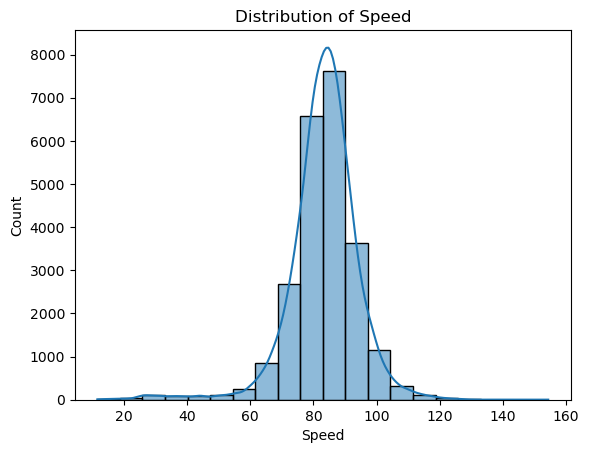

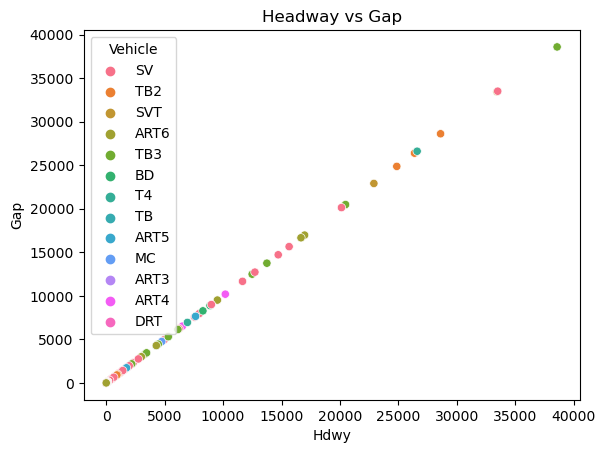

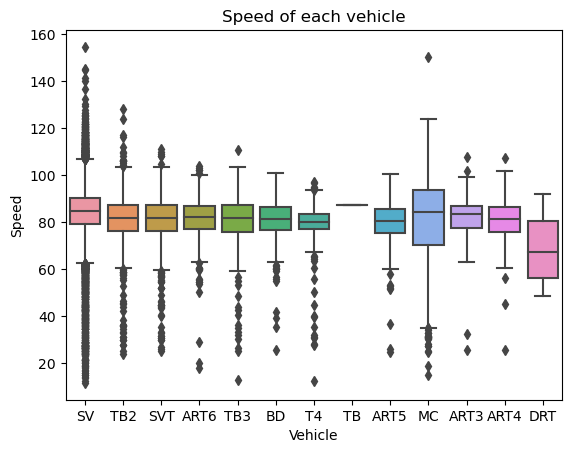

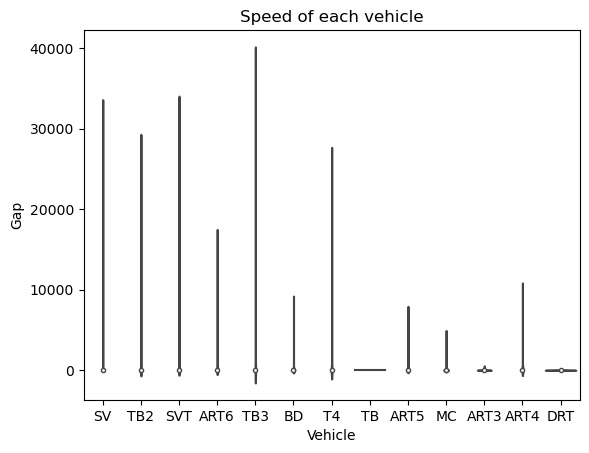

In [3]:
# Data visualization for some key features
sns.histplot(data["Speed"], bins=20, kde=True)
plt.title("Distribution of Speed")
plt.show()

sns.scatterplot(x="Hdwy", y="Gap", data=data, hue="Vehicle")
plt.title("Headway vs Gap")
plt.show()

# plot a boxplot for the speed of each vehicle
sns.boxplot(x="Vehicle", y="Speed", data=data)
plt.title("Speed of each vehicle")
plt.show()

#plot a violin plot for the speed of each vehicle
sns.violinplot(x="Vehicle", y="Gap", data=data)
plt.title("Speed of each vehicle")
plt.show()


In [4]:
# Feature Engineering

# Convert 'YYYY-MM-DD' and 'hh:mm:ss' to datetime format
data["Date"] = pd.to_datetime(data["YYYY-MM-DD"])
data["Time"] = pd.to_datetime(data["hh:mm:ss"], format='%H:%M:%S')

# Extract date and time features
data["Day"] = data["Date"].dt.day
data["Month"] = data["Date"].dt.month
data["Year"] = data["Date"].dt.year
data["Hour"] = data["Time"].dt.hour
data["Minute"] = data["Time"].dt.minute
data["Second"] = data["Time"].dt.second

# Convert 'YYYY-MM-DD' and 'hh:mm:ss' to datetime format
data["DateTime"] = pd.to_datetime(data["YYYY-MM-DD"] + " " + data["hh:mm:ss"])

# Drop original date and time columns
# data.drop(["YYYY-MM-DD", "hh:mm:ss"], axis=1, inplace=True)

data.head()

,Ht,YYYY-MM-DD,hh:mm:ss,Dr,Speed,Wb,Hdwy,Gap,Ax,Gp,...,Vehicle,Date,Time,Day,Month,Year,Hour,Minute,Second,DateTime
0,4,2023-11-5,13:00:12,N0,81.02,2.39,19.4,19.3,2,2,...,SV,2023-11-05,1900-01-01 13:00:12,5,11,2023,13,0,12,2023-11-05 13:00:12
1,4,2023-11-5,13:00:13,N0,81.43,2.79,1.6,1.5,2,2,...,SV,2023-11-05,1900-01-01 13:00:13,5,11,2023,13,0,13,2023-11-05 13:00:13
2,4,2023-11-5,13:00:15,N0,86.87,2.71,1.8,1.6,2,2,...,SV,2023-11-05,1900-01-01 13:00:15,5,11,2023,13,0,15,2023-11-05 13:00:15
3,4,2023-11-5,13:00:16,N0,93.67,2.79,0.7,0.6,2,2,...,SV,2023-11-05,1900-01-01 13:00:16,5,11,2023,13,0,16,2023-11-05 13:00:16
4,4,2023-11-5,13:00:43,N0,87.55,3.00,27.4,27.3,2,2,...,SV,2023-11-05,1900-01-01 13:00:43,5,11,2023,13,0,43,2023-11-05 13:00:43


In [5]:
# Calculate acceleration
data["Acceleration"] = data["Speed"].diff() / data["Time"].diff().dt.total_seconds()

# Fill NaN values in acceleration column
data["Acceleration"].fillna(0, inplace=True)


### Statistical Aggreagtions to compute the mean , median, std for relevant features  grouped by different factors

In [6]:
# Example: Mean speed for each vehicle
vehicle_stats = data.groupby("Vehicle")["Speed"].mean().reset_index()
vehicle_stats.columns = ["Vehicle", "Mean_Speed"]

# Merge the aggregated statistics back to the original dataset
data = pd.merge(data, vehicle_stats, on="Vehicle", how="left")
data.head()

,Ht,YYYY-MM-DD,hh:mm:ss,Dr,Speed,Wb,Hdwy,Gap,Ax,Gp,...,Time,Day,Month,Year,Hour,Minute,Second,DateTime,Acceleration,Mean_Speed
0,4,2023-11-5,13:00:12,N0,81.02,2.39,19.4,19.3,2,2,...,1900-01-01 13:00:12,5,11,2023,13,0,12,2023-11-05 13:00:12,0.000000,84.039293
1,4,2023-11-5,13:00:13,N0,81.43,2.79,1.6,1.5,2,2,...,1900-01-01 13:00:13,5,11,2023,13,0,13,2023-11-05 13:00:13,0.410000,84.039293
2,4,2023-11-5,13:00:15,N0,86.87,2.71,1.8,1.6,2,2,...,1900-01-01 13:00:15,5,11,2023,13,0,15,2023-11-05 13:00:15,2.720000,84.039293
3,4,2023-11-5,13:00:16,N0,93.67,2.79,0.7,0.6,2,2,...,1900-01-01 13:00:16,5,11,2023,13,0,16,2023-11-05 13:00:16,6.800000,84.039293
4,4,2023-11-5,13:00:43,N0,87.55,3.00,27.4,27.3,2,2,...,1900-01-01 13:00:43,5,11,2023,13,0,43,2023-11-05 13:00:43,-0.226667,84.039293


### Time-based Features:
 - Create features like 'Time since last event' or 'Time to next event'.

In [7]:
# Calculate time since the last event
data["Time_Since_Last_Event"] = data["Time"].diff().dt.total_seconds()

# Fill NaN values in time-based features
data["Time_Since_Last_Event"].fillna(0, inplace=True)

data.head()

,Ht,YYYY-MM-DD,hh:mm:ss,Dr,Speed,Wb,Hdwy,Gap,Ax,Gp,...,Day,Month,Year,Hour,Minute,Second,DateTime,Acceleration,Mean_Speed,Time_Since_Last_Event
0,4,2023-11-5,13:00:12,N0,81.02,2.39,19.4,19.3,2,2,...,5,11,2023,13,0,12,2023-11-05 13:00:12,0.000000,84.039293,0.0
1,4,2023-11-5,13:00:13,N0,81.43,2.79,1.6,1.5,2,2,...,5,11,2023,13,0,13,2023-11-05 13:00:13,0.410000,84.039293,1.0
2,4,2023-11-5,13:00:15,N0,86.87,2.71,1.8,1.6,2,2,...,5,11,2023,13,0,15,2023-11-05 13:00:15,2.720000,84.039293,2.0
3,4,2023-11-5,13:00:16,N0,93.67,2.79,0.7,0.6,2,2,...,5,11,2023,13,0,16,2023-11-05 13:00:16,6.800000,84.039293,1.0
4,4,2023-11-5,13:00:43,N0,87.55,3.00,27.4,27.3,2,2,...,5,11,2023,13,0,43,2023-11-05 13:00:43,-0.226667,84.039293,27.0


 - Deriving Speed Limits


In [8]:
# Define a speed limit (e.g., 70 units)
speed_limit = 70

# Create a binary feature indicating whether the speed exceeds the limit
data["Exceeds_Speed_Limit"] = data["Speed"] > speed_limit

data.head()

,Ht,YYYY-MM-DD,hh:mm:ss,Dr,Speed,Wb,Hdwy,Gap,Ax,Gp,...,Month,Year,Hour,Minute,Second,DateTime,Acceleration,Mean_Speed,Time_Since_Last_Event,Exceeds_Speed_Limit
0,4,2023-11-5,13:00:12,N0,81.02,2.39,19.4,19.3,2,2,...,11,2023,13,0,12,2023-11-05 13:00:12,0.000000,84.039293,0.0,True
1,4,2023-11-5,13:00:13,N0,81.43,2.79,1.6,1.5,2,2,...,11,2023,13,0,13,2023-11-05 13:00:13,0.410000,84.039293,1.0,True
2,4,2023-11-5,13:00:15,N0,86.87,2.71,1.8,1.6,2,2,...,11,2023,13,0,15,2023-11-05 13:00:15,2.720000,84.039293,2.0,True
3,4,2023-11-5,13:00:16,N0,93.67,2.79,0.7,0.6,2,2,...,11,2023,13,0,16,2023-11-05 13:00:16,6.800000,84.039293,1.0,True
4,4,2023-11-5,13:00:43,N0,87.55,3.00,27.4,27.3,2,2,...,11,2023,13,0,43,2023-11-05 13:00:43,-0.226667,84.039293,27.0,True


 - Extract day of the week and time of the day from timestamp

In [9]:
# Extract day of the week (0 = Monday, 6 = Sunday)
data["Day_of_Week"] = data["Date"].dt.dayofweek

# Extract time of day (morning, afternoon, evening, night)
data["Time_of_Day"] = pd.cut(
    data["Hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False,
)

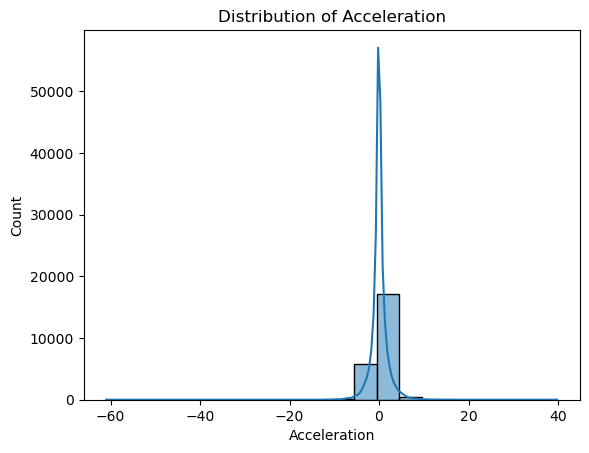

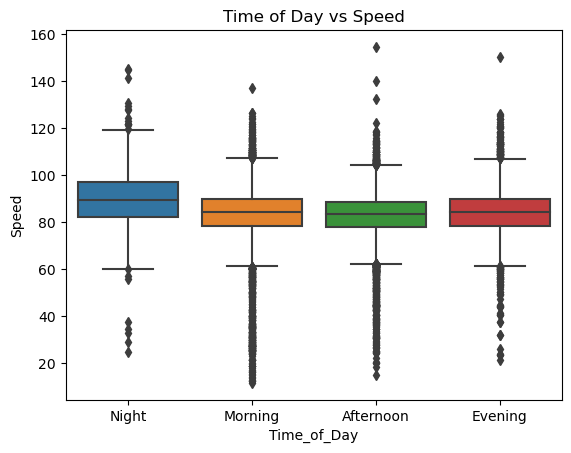

In [10]:
# create visualizations for the new features
sns.histplot(data["Acceleration"], bins=20, kde=True)
plt.title("Distribution of Acceleration")
plt.show()

# create plot shwoing the comparision between the time of day and speed
sns.boxplot(x="Time_of_Day", y="Speed", data=data)
plt.title("Time of Day vs Speed")
plt.show()

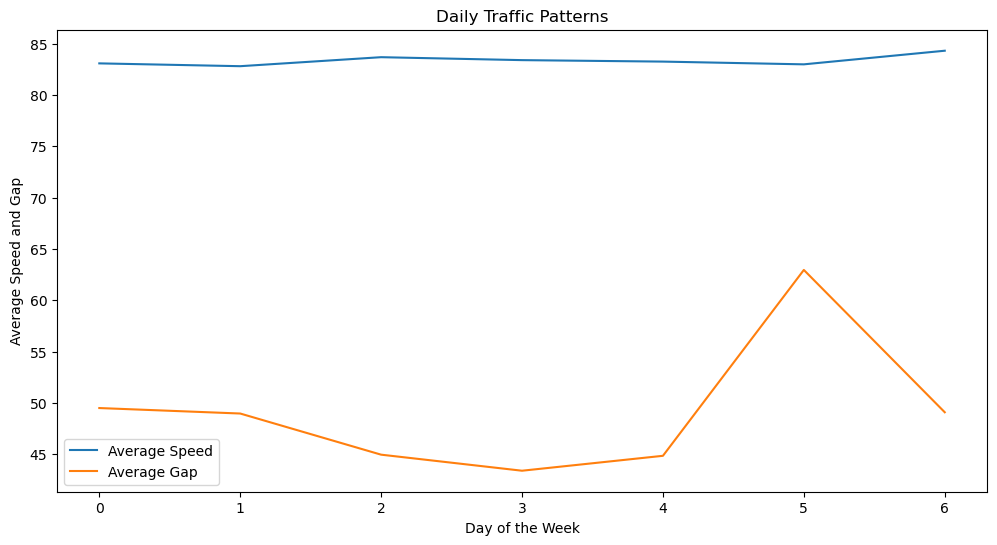

In [11]:
## Daily Traffic Patterns
# Group by day and calculate average speed and gap
daily_traffic = data.groupby("Day_of_Week")[["Speed", "Gap"]].mean().reset_index()

# Plot daily traffic patterns
plt.figure(figsize=(12, 6))
sns.lineplot(x="Day_of_Week", y="Speed", data=daily_traffic, label="Average Speed")
sns.lineplot(x="Day_of_Week", y="Gap", data=daily_traffic, label="Average Gap")
plt.title("Daily Traffic Patterns")
plt.xlabel("Day of the Week")
plt.ylabel("Average Speed and Gap")
plt.show()

## Weekly Traffic Patterns
# Group by week and calculate average speed and gap
# weekly_traffic = (
#     data.groupby(data["Time"].dt.isocalendar().week)[["Speed", "Gap"]].mean().reset_index()
# )

# weekly_traffic.head()

# Plot weekly traffic patterns
# plt.figure(figsize=(12, 6))
# sns.lineplot(x="week", y="Speed", data=weekly_traffic, label="Average Speed")
# sns.lineplot(x="week", y="Gap", data=weekly_traffic, label="Average Gap")
# plt.title("Weekly Traffic Patterns")
# plt.xlabel("Week of the Year")
# plt.ylabel("Average Speed and Gap")
# plt.show()


## Impact of WEekends

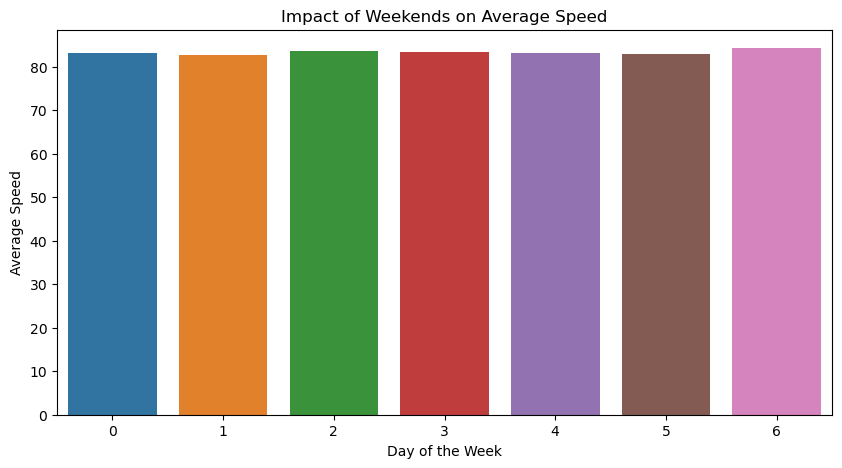

In [12]:
# Group by day of the week and calculate average speed and gap
day_of_week_traffic = data.groupby("Day_of_Week")[["Speed", "Gap"]].mean().reset_index()

# Plot the impact of weekends on traffic
plt.figure(figsize=(10, 5))
sns.barplot(x="Day_of_Week", y="Speed", data=day_of_week_traffic)
plt.title("Impact of Weekends on Average Speed")
plt.xlabel("Day of the Week")
plt.ylabel("Average Speed")
plt.show()

In [20]:
# Create a new feature for traffic flow intensity
data["Traffic_Flow"] = data["Speed"] / data["Gap"]
print(data["Traffic_Flow"].count())

# Group by time of day and day of the week and calculate average traffic flow
traffic_flow_by_time = (
    data.groupby(["Time_of_Day", "Day_of_Week"])["Traffic_Flow"].mean().reset_index()
)

traffic_flow_by_time

# # Plot traffic flow by time of day and day of the week
# plt.figure(figsize=(14, 8))
# heatmap_data = traffic_flow_by_time.pivot(
#     index="Day_of_Week", columns="Time_of_Day", values="Traffic_Flow"
# )
# sns.heatmap(
#     heatmap_data,
#     cmap="YlGnBu",
#     annot=True,
#     fmt=".2f",
#     cbar_kws={"label": "Average Traffic Flow"},
# )
# plt.title("Traffic Flow by Time of Day and Day of the Week")
# plt.show()

23692


,Time_of_Day,Day_of_Week,Traffic_Flow
0,Night,0,5.536574
1,Night,1,4.709444
2,Night,2,5.648787
3,Night,3,NaN
4,Night,4,4.124631
5,Night,5,NaN
6,Night,6,7.034618
7,Morning,0,NaN
8,Morning,1,NaN
9,Morning,2,NaN


In [ ]:
# print the data types of the columns
print(data.dtypes)

# perform one-hot encoding for the categorical variables using label encoding
label_encoder = LabelEncoder()
cat_columns = ["Dr", "Vehicle", "Time_of_Day", "Exceeds_Speed_Limit"]
data[cat_columns] = data[cat_columns].apply(LabelEncoder().fit_transform)

# check missing values
print("\nMissing Values Count\n", data.isnull().sum())

# Standardize the features
scaler = StandardScaler()

# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
data.dropna(inplace=True)

In [ ]:
# For Traffic Congestion Prediction
congestion_features = ["Speed", "Gap", "Traffic_Flow", "Time_of_Day", "Day_of_Week"]
congestion_target = "Exceeds_Speed_Limit"


# Split the dataset for each prediction task
X_congestion = data[congestion_features]
y_congestion = data[congestion_target]

print(X_congestion.head())

# Split the datasets into training and testing sets
X_congestion_train, X_congestion_test, y_congestion_train, y_congestion_test = (
    train_test_split(X_congestion, y_congestion, test_size=0.2, random_state=42)
)

X_congestion_train_scaled = scaler.fit_transform(X_congestion_train)
X_congestion_test_scaled = scaler.transform(X_congestion_test)

# Define hyperparameters for tuning
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Initialize and fit GridSearchCV for hyperparameter tuning
rf_congestion_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf_congestion_classifier, param_grid, cv=5, scoring="accuracy", n_jobs=-1
)
grid_search.fit(X_congestion_train_scaled, y_congestion_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_rf_congestion_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_congestion_classifier.fit(X_congestion_train_scaled, y_congestion_train)

# Make predictions
congestion_predictions = best_rf_congestion_classifier.predict(X_congestion_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_congestion_test, congestion_predictions)
print("Traffic Congestion Prediction Accuracy:", accuracy)

In [ ]:
# For Traffic Incident Probability Prediction
incident_features = [
    "Speed",
    "Gap",
    "Time_Since_Last_Event",
    "Day_of_Week",
    "Time_of_Day",
]
incident_target = "Traffic_Flow"  # You can change the target variable as needed

# Split the dataset
X_incident = data[incident_features]
y_incident = data[incident_target]
X_incident_train, X_incident_test, y_incident_train, y_incident_test = train_test_split(
    X_incident, y_incident, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_incident_train_scaled = scaler.fit_transform(X_incident_train)
X_incident_test_scaled = scaler.transform(X_incident_test)

# Define hyperparameters for tuning
param_grid_incident = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Initialize and fit GridSearchCV for hyperparameter tuning
rf_incident_regressor = RandomForestRegressor(random_state=42)
grid_search_incident = GridSearchCV(
    rf_incident_regressor,
    param_grid_incident,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)
grid_search_incident.fit(X_incident_train_scaled, y_incident_train)

# Get the best hyperparameters
best_params_incident = grid_search_incident.best_params_

# Train the model with the best hyperparameters
best_rf_incident_regressor = RandomForestRegressor(
    random_state=42, **best_params_incident
)
best_rf_incident_regressor.fit(X_incident_train_scaled, y_incident_train)

# Make predictions
incident_predictions = best_rf_incident_regressor.predict(X_incident_test_scaled)

# Evaluate the model
mae_incident = mean_absolute_error(y_incident_test, incident_predictions)
print("Traffic Incident Probability Prediction Mean Absolute Error:", mae_incident)

In [ ]:
# Define features and target variables for Optimal Traffic Flow Prediction
optimal_flow_features = ["Speed", "Gap", "Traffic_Flow", "Time_of_Day", "Day_of_Week"]
optimal_flow_target = "Mean_Speed"

# Split the dataset
X_optimal_flow = data[optimal_flow_features]
y_optimal_flow = data[optimal_flow_target]
X_optimal_flow_train, X_optimal_flow_test, y_optimal_flow_train, y_optimal_flow_test = (
    train_test_split(X_optimal_flow, y_optimal_flow, test_size=0.2, random_state=42)
)

# Standardize the features
X_optimal_flow_train_scaled = scaler.fit_transform(X_optimal_flow_train)
X_optimal_flow_test_scaled = scaler.transform(X_optimal_flow_test)

# Define hyperparameters for tuning
param_grid_optimal_flow = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Initialize and fit GridSearchCV for hyperparameter tuning
rf_optimal_flow_regressor = RandomForestRegressor(random_state=42)
grid_search_optimal_flow = GridSearchCV(
    rf_optimal_flow_regressor, param_grid_optimal_flow, cv=5, scoring="r2", n_jobs=-1
)
grid_search_optimal_flow.fit(X_optimal_flow_train_scaled, y_optimal_flow_train)

# Get the best hyperparameters
best_params_optimal_flow = grid_search_optimal_flow.best_params_

# Train the model with the best hyperparameters
best_rf_optimal_flow_regressor = RandomForestRegressor(
    random_state=42, **best_params_optimal_flow
)
best_rf_optimal_flow_regressor.fit(X_optimal_flow_train_scaled, y_optimal_flow_train)

# Make predictions
optimal_flow_predictions = best_rf_optimal_flow_regressor.predict(
    X_optimal_flow_test_scaled
)

# Evaluate the model
r2_optimal_flow = r2_score(y_optimal_flow_test, optimal_flow_predictions)
print("Optimal Traffic Flow Prediction R-squared:", r2_optimal_flow)

In [21]:
# Convert 'YYYY-MM-DD' and 'hh:mm:ss' to datetime format
data["DateTime"] = pd.to_datetime(data["YYYY-MM-DD"] + " " + data["hh:mm:ss"])

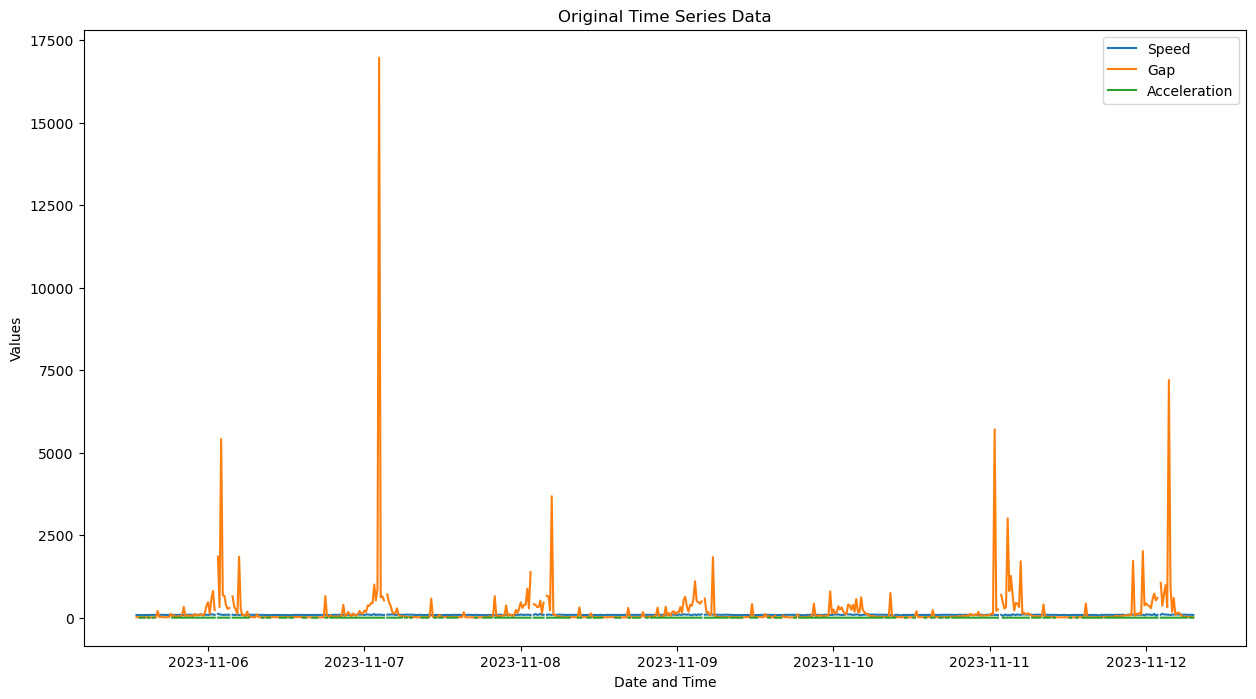

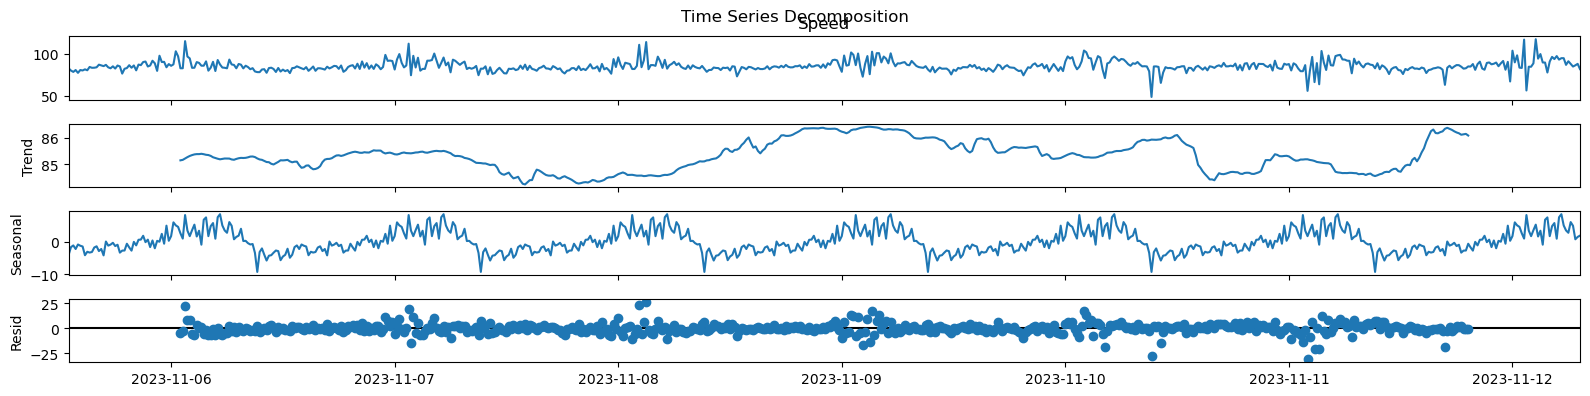

In [22]:
# Set DateTime as the index
data.set_index("DateTime", inplace=True)

# Extract relevant columns for time series analysis
ts_columns = ["Speed", "Gap", "Acceleration"]

# Resample the data to a regular time frequency (e.g., 15 minutes)
resampled_data = data[ts_columns].resample("15T").mean()

# Plot the original time series data
plt.figure(figsize=(15, 8))
for column in ts_columns:
    plt.plot(resampled_data.index, resampled_data[column], label=column)

plt.title("Original Time Series Data")
plt.xlabel("Date and Time")
plt.ylabel("Values")
plt.legend()
plt.show()

# Forward fill missing values
resampled_data["Speed"].fillna(method="ffill", inplace=True)

# Decompose the time series into trend, seasonality, and residual components
decomposition = seasonal_decompose(
    resampled_data["Speed"], model="additive", period=96
)  # Assuming daily seasonality

# Plot the decomposed components
rcParams["figure.figsize"] = 16, 4
decomposition.plot()
plt.suptitle("Time Series Decomposition")
plt.show()